In [45]:
import sys
from scipy.spatial.distance import cdist
import tqdm
import mne
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from mk_stuff_table import stuff_table
from matplotlib.backends.backend_pdf import PdfPages


######################
# Setting parameters
event_id = {'odd': 1, 'norm': 2, 'button': 3, 'clear_norm': 4}
# Bands
bands = [(0, 4, 'Delta'),
         (4, 8, 'Theta'),
         (8, 12, 'Alpha'),
         (12, 30, 'Beta'),
         (30, 45, 'Gamma')]
# Targe Delta band
band = [e for e in bands if e[-1] == 'Delta'][0]
l_freq, h_freq = band[0], band[1]
# define frequencies of interest (log-spaced)
freqs = np.logspace(*np.log10([1, 4]), num=10)
# different number of cycle per frequency
n_cycles = freqs / 2
# Events
# event_id = {'odd': 1, 'norm': 2, 'button': 3, 'clear_norm': 4}
# event_id = {'odd': 1, 'clear_norm': 4}
# Time range
tmin, tmax = 0.0, 0.8
# n_jobs
n_jobs = 16
# Initialize Xdawn
xdawn = mne.preprocessing.Xdawn(n_components=6, reg='diagonal_fixed')

# Identify data we want
data_id = 'MEG_S02'
print(data_id)
stuff = stuff_table[data_id]
# Check the stuff
pprint(stuff)

# Initialize empty epochs_list
epochs_list = []
# For each epochs, read it and append it into epochs_list
for session_id in [4, 6]:  # stuff['session_range']:
    epochs_path = stuff['epochs_path'] % session_id
    print(epochs_path)

    # Read epochs
    _epochs = mne.read_epochs(epochs_path)[['odd', 'button', 'clear_norm']]

    # !!! 'Align' epochs
    if len(epochs_list) > 0:
        _epochs.info['dev_head_t'] = epochs_list[0].info['dev_head_t']

    # Append epochs
    epochs_list.append(_epochs)

# Concatenate epochs in epochs_list
epochs_concatenate = mne.epochs.concatenate_epochs(epochs_list)
# Filter epochs_concatenate
epochs_concatenate = epochs_concatenate.filter(l_freq=l_freq, h_freq=h_freq,
                                               n_jobs=n_jobs, verbose=2)

MEG_S02
{'cov_path': 'd:\\RSVP_MEG_experiment\\epochs_saver\\epochs_freq_1.0_50.0\\MEG_S02_R%02d\\raw-epo-cov.fif',
 'denoised_epochs_path': 'd:\\RSVP_MEG_experiment\\epochs_saver\\epochs_freq_1.0_50.0\\MEG_S02_R%02d\\denoised-epo.fif',
 'epochs_path': 'd:\\RSVP_MEG_experiment\\epochs_saver\\epochs_freq_1.0_50.0\\MEG_S02_R%02d\\raw-epo.fif',
 'evoked_freq_report_path': 'd:\\RSVP_MEG_experiment\\epochs_saver\\epochs_freq_1.0_50.0\\MEG_S02_R%02d\\evoked_freq_report.pdf',
 'evoked_joint_report_path': 'd:\\RSVP_MEG_experiment\\epochs_saver\\epochs_freq_1.0_50.0\\MEG_S02_R%02d\\evoked_joint_report.pdf',
 'raw_ica_fif_path': 'd:\\RSVP_MEG_experiment\\epochs_saver\\epochs_freq_1.0_50.0\\MEG_S02_R%02d\\raw_ica.fif',
 'raw_ica_report_path': 'd:\\RSVP_MEG_experiment\\epochs_saver\\epochs_freq_1.0_50.0\\MEG_S02_R%02d\\raw_ica_report.pdf',
 'rawfile_path': 'd:\\RSVP_MEG_experiment\\rawdata\\20190326_RSVP_MEG_maxuelin\\S02_lixiangTHU_20190326_%02d.ds',
 'session_range': range(4, 12),
 'subject_id':

<ipython-input-45-98525c6365bb>:66: RuntimeWarning: filter_length (331) is longer than the signal (240), distortion is likely. Reduce filter length or filter a longer signal.
  n_jobs=n_jobs, verbose=2)


Using filter length: 331
Smart-padding with:  239 samples on each edge
FFT block length:   1024


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 7104 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 30684 tasks      | elapsed:    2.4s
[Parallel(n_jobs=16)]: Done 63696 tasks      | elapsed:    4.8s
[Parallel(n_jobs=16)]: Done 106140 tasks      | elapsed:    7.8s
[Parallel(n_jobs=16)]: Done 158016 tasks      | elapsed:   11.3s
[Parallel(n_jobs=16)]: Done 219324 tasks      | elapsed:   15.5s
[Parallel(n_jobs=16)]: Done 231744 out of 231744 | elapsed:   16.2s finished


In [46]:
def compute_dists(epochs):
    label = epochs.events[:, -1]
    times = epochs.times

    print(epochs.get_data().shape)
    print(label.shape, np.unique(label))
    print(times.shape)

    dnn = []
    doo = []
    dno = []
    pbar = tqdm.tqdm(total=len(times))
    for j, time in enumerate(times):
        pbar.update(1)
        norm = epochs['clear_norm'].get_data()[:, :, j]
        odd = epochs['odd'].get_data()[:, :, j]

        nn = cdist(norm, norm)
        oo = cdist(odd, odd)
        no = cdist(norm, odd)

        dnn.append(np.mean(nn))
        doo.append(np.mean(oo))
        dno.append(np.mean(no))

    pbar.close()

    return dnn, doo, dno


times = epochs_concatenate.times
# Fit xdawn use epochs
xdawn.fit(epochs_concatenate)
# Apply xdawn to denoise
epochs_denoised = xdawn.apply(epochs_concatenate.copy(),
                              event_id=['odd'])['odd']

dnn, doo, dno = compute_dists(epochs_concatenate)
dnnd, dood, dnod = compute_dists(epochs_denoised)

print('Done.')

(852, 272, 240)
(852,) [1 3 4]
(240,)



100%|████████████████████████████████████████| 240/240 [01:28<00:00,  2.70it/s]


(852, 272, 240)
(852,) [1 3 4]
(240,)



100%|████████████████████████████████████████| 240/240 [01:29<00:00,  2.69it/s]


Done.


MEG_S02


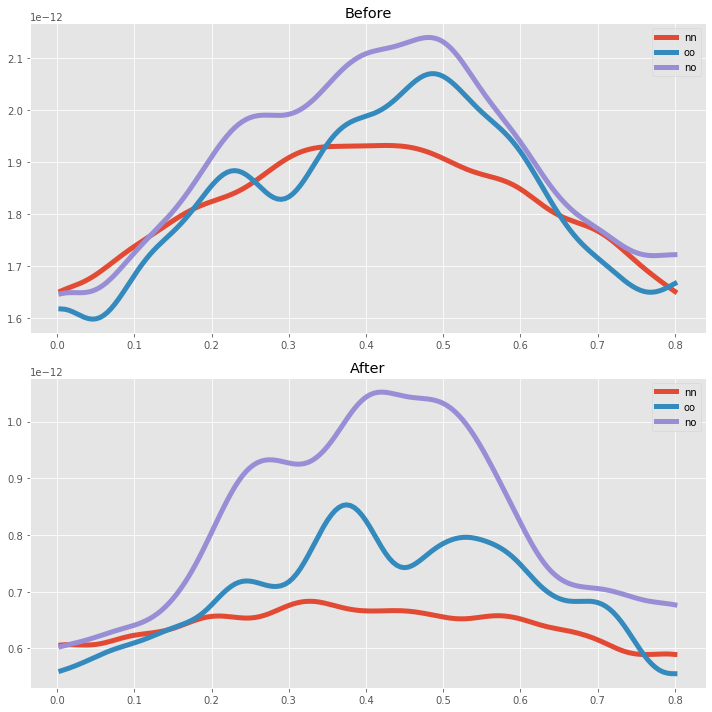

In [47]:
plt.style.use('ggplot')

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

select = times > tmin
select[times > tmax] = False

ax = axes[0]
for data, label in zip([dnn, doo, dno], ['nn', 'oo', 'no']):
    ax.plot(times[select], np.array(data)[select], label=label, linewidth=5)
ax.legend()
ax.set_title('Before')

ax = axes[1]
for data, label in zip([dnnd, dood, dnod], ['nn', 'oo', 'no']):
    ax.plot(times[select], np.array(data)[select], label=label, linewidth=5)
ax.legend()
ax.set_title('After')

print(data_id)
fig.tight_layout()
plt.rcParams.update({'font.size': 10})
plt.show()

In [36]:
dir(fig)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_axes_internal',
 '_agg_filter',
 '_align_xlabel_grp',
 '_align_ylabel_grp',
 '_alpha',
 '_animated',
 '_axobservers',
 '_axstack',
 '_cachedRenderer',
 '_clipon',
 '_clippath',
 '_constrained',
 '_constrained_layout_pads',
 '_contains',
 '_dpi',
 '_gci',
 '_get_axes',
 '_get_clipping_extent_bbox',
 '_get_dpi',
 '_gid',
 '_gridspecs',
 '_in_layout',
 '_label',
 '_layoutbox',
 '_make_key',
 '_mouseover',
 '_oid',
 '_path_effects',
 '_picker',
 '_process_projection_requirements',
 '_prop_order',
 '_propobservers',
 '_rasterized',
 '_remove_ax',
 '_remove_method',
 '_repr_html_',
 '_set